In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
# 데이터를 인위적으로 변형하여 증가(학습데이터 부족시 사용)
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [ ]:
# 데이터 로드
x_train = np.load('dataset/x_train.npy').astype(np.float32) 
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
# 0: 눈 감음 / 1: 눈 뜸

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


# Preview

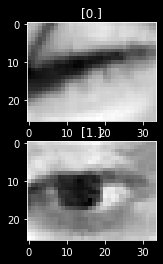

In [ ]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

# Data Augmentation

In [ ]:
# 데이터가 부족할 때 사용 -> 이미지형태가 다양해지므로 모델이 좀 더 잘 학습할 수 있음
train_datagen = ImageDataGenerator( # 이미지 처리를 도와주는 클래스
    rescale=1./255, # 원래이미지(0~255) -> 255로 나누어 줌으로써 0~1 값으로 변경
    rotation_range=10, # 10도 돌리기
    width_shift_range=0.2, # 가로크기 변경
    height_shift_range=0.2, # 세로크기 변경
    shear_range=0.2 # 이미지를 약간 비틈
)

# 검증 데이터셋은 데이터를 비틀 필요가 없으므로 rescale만 진행
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32, # 32개씩 데이터 꺼내옴
    shuffle=True # 순서를 섞음
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [ ]:
inputs = Input(shape=(26, 34, 1)) # 세로26 가로34 그레이스케일인 이미지

# 커널수만 변경 32->64->128
net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net) # 차원축소

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net) # convolution & Pooling layer(특징추출)를 1차원으로 펴줌

net = Dense(512)(net) # 512개로 수렴. fully-connected layer(분류)와 연결
net = Activation('relu')(net)
net = Dense(1)(net) # 마지막 레이어는 1개(0~1사이 값 1개로로 나오게 함)
outputs = Activation('sigmoid')(net) # 거의 0, 거의 1에 가까운 0~1사이값으로 나오게 됨

model = Model(inputs=inputs, outputs=outputs) # 모델에 input, output 정의

# binary_crossentropy : 0이냐? 1이냐?
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

# 880,129 파라미터를 학습시킬 예정

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 34, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 4, 128)         0   

# Train

In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

# generator로 데이터를 로드했을 경우 fit_generator로 학습시켜주는 것이 좋음
# 반복학습 : 50번
model.fit_generator( 
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        # 모델이 좋으면 저장해라
        ModelCheckpoint('models/blink/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        # 학습이 잘 안된다면 러닝레이트를 줄여라
        # plateau : 정체기라는 의미
        # 모델의 정확도가 향상되지 않는 경우 learning rate(lr) 줄여주는 클래스
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
81/81 [==============================] - 2s 30ms/step - loss: 0.1784 - acc: 0.9377 - val_loss: 0.0563 - val_acc: 0.9722

Epoch 00001: val_acc improved from -inf to 0.97222, saving model to models/2020_10_22_14_47_26.h5
Epoch 2/50
81/81 [==============================] - 2s 29ms/step - loss: 0.1352 - acc: 0.9520 - val_loss: 0.0445 - val_acc: 0.9792

Epoch 00002: val_acc improved from 0.97222 to 0.97917, saving model to models/2020_10_22_14_47_26.h5
Epoch 3/50
81/81 [==============================] - 2s 30ms/step - loss: 0.1075 - acc: 0.9637 - val_loss: 0.0240 - val_acc: 0.9826

Epoch 00003: val_acc improved from 0.97917 to 0.98264, saving model to models/2020_10_22_14_47_26.h5
Epoch 4/50
81/81 [==============================] - 3s 31ms/step - loss: 0.0903 - acc: 0.9671 - val_loss: 0.0176 - val_acc: 0.9792

Epoch 00004: val_acc did not improve from 0.98264
Epoch 5/50
81/81 [==============================] - 2s 31ms/step - loss: 0.0884 - acc: 0.9710 - val_loss: 0.0130 - val_acc

81/81 [==============================] - 4s 43ms/step - loss: 0.0069 - acc: 0.9988 - val_loss: 0.0016 - val_acc: 0.9931

Epoch 00043: val_acc did not improve from 0.99653
Epoch 44/50
81/81 [==============================] - 3s 35ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.0015 - val_acc: 0.9931

Epoch 00044: val_acc did not improve from 0.99653
Epoch 45/50
81/81 [==============================] - 3s 34ms/step - loss: 0.0069 - acc: 0.9977 - val_loss: 0.0019 - val_acc: 0.9931

Epoch 00045: val_acc did not improve from 0.99653
Epoch 46/50
81/81 [==============================] - 3s 35ms/step - loss: 0.0051 - acc: 0.9977 - val_loss: 0.0017 - val_acc: 0.9931

Epoch 00046: val_acc did not improve from 0.99653
Epoch 47/50
81/81 [==============================] - 3s 35ms/step - loss: 0.0059 - acc: 0.9985 - val_loss: 0.0016 - val_acc: 0.9931

Epoch 00047: val_acc did not improve from 0.99653
Epoch 48/50
81/81 [==============================] - 3s 37ms/step - loss: 0.0082 - acc: 0.9977 - 

# Confusion Matrix
- 모델이 얼마나 잘 학습했는지 확인

test acc: 0.9965277777777778


<AxesSubplot:>

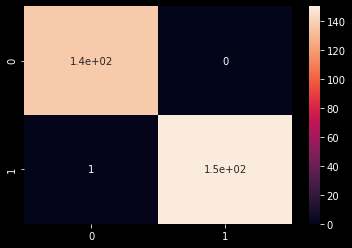

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix # 정확도점수, 오차행렬
import seaborn as sns

model = load_model('models/blink/%s.h5' % (start_time)) # 모델 로드

y_pred = model.predict(x_val/255.) # 검증 이미지데이터로 예측, 이미지 0~1로 바꿔서
y_pred_logical = (y_pred > 0.5).astype(np.int) # 0.5미만(눈 감음) / 나머지(눈뜸), True.. -> int형 변환 -> 0 or 1

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

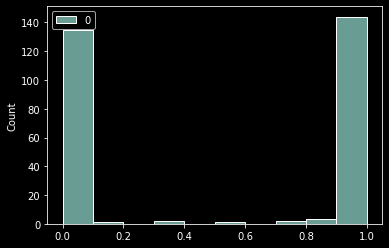

In [ ]:
ax = sns.histplot(y_pred, kde=False)